In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

from utils import display_prediction, decode_segmap
from Cityscapes import Cityscapes
from bisenetv2 import BiSeNetV2

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 8       # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 3      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 25        # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1           # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

RESIZED_H = 512
RESIZED_W = 1024

MODE = 'LOAD_AND_TRAIN'       #TRAIN or LOAD_AND_TRAIN or LOAD
MODEL_PATH = 'checkpoints/modelLarger.tar' #File to save the model in

Running on cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


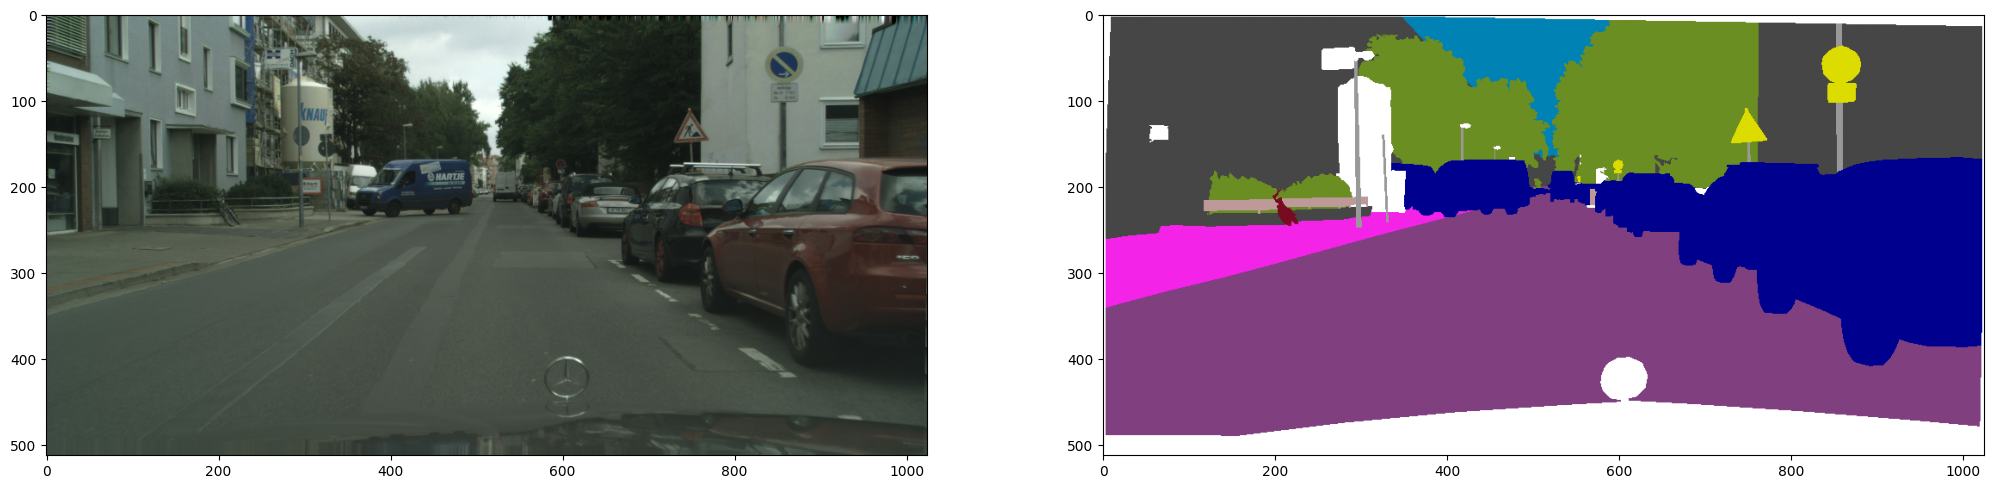

In [12]:
mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]
normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((RESIZED_H, RESIZED_W), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([resizer_bicubic])
eval_transform = transforms.Compose([resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])

train_dataset = Cityscapes('data/', partition_type='B', split='train', transform=train_transform, target_transform=target_transform)
test_dataset = Cityscapes('data/', partition_type='B', split='val', transform=eval_transform, target_transform=target_transform)

i, l = train_dataset.__getitem__(101)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
l = decode_segmap(l.squeeze())
plt.imshow(l)
plt.show()

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.to(DEVICE)

In [15]:
# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=255) # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of the net
# (nn.Module objects implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [9]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

In [16]:
def train_epoch(net, dataloader, lr=0.01, optimizer=optimizer, loss_fn=criterion):
    net.train()

    total_loss, miou, count = 0, 0, 0
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.squeeze().to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()

        out = net(images)
        loss = loss_fn(out, masks) 
        loss.backward()
        optimizer.step()

        total_loss += loss
        miou += metric(out, masks)
        count += 1
        if i%LOG_FREQUENCY == 0:
            print("  minibatch {}: train mIoU = {} train loss = {}".format(i, miou.item()/count, total_loss.item()/count))
    return total_loss.item()/count, miou.item()/count

def validate(net, dataloader, loss_fn=criterion):
    net.eval()
    loss, miou, count = 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(DEVICE)
            masks = masks.squeeze().to(DEVICE)

            out = net(images)
            loss += loss_fn(out, masks) 
            miou += metric(out, masks)
            count += 1
    return loss.item()/count, miou.item()/count

def train(net, train_loader, test_loader, history=None, starting_epoch=0, optimizer=optimizer, lr=0.01, epochs=10, loss_fn=criterion):
    history = history or {'train_loss' : [0.0], 'train_miou': [0.0], 'val_loss': [0.0], 'val_miou': [0.0]} 

    print(f'Lr: {lr}\nBatch size: {BATCH_SIZE}\nEpochs: {epochs}\nLoss function: {loss_fn}\nOptimizer: {optimizer}')

    for ep in range(starting_epoch, starting_epoch + epochs):
        print(f'----------- EPOCH {ep+1} -----------')
        train_loss, train_miou = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        val_loss, val_miou = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Train mIoU={train_miou:.3f}, Val mIoU={val_miou:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        
        save = False
        if val_miou > max(history['val_miou']): #If this is the best validation mIoU, save the model
            save = True
            print(f"MODEL SAVED WITH mIoU = {val_miou}") 

        history['train_loss'].append(train_loss)
        history['train_miou'].append(train_miou)
        history['val_loss'].append(val_loss)
        history['val_miou'].append(val_miou)
        display_prediction(net, test_dataset, random=False)
        scheduler.step()
                
        if save == True:
            torch.save({
                'model_state_dict': net.state_dict(),
                'optim_state_dict': optimizer.state_dict(),
                'epoch': ep,
                'history': history,
                'batch_size': BATCH_SIZE,
                'lr': lr,
                'resized_height': RESIZED_H,
                'resized_width': RESIZED_W,
            }, MODEL_PATH)

    return history

def plot_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['train_miou'], label='Training mIoU')
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.legend()
    plt.subplot(122)
    plt.plot(history['train_loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()

Loaded pre-trained model at epoch 115
Lr: 0.05
Batch size: 8
Epochs: 3
Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
----------- EPOCH 116 -----------
  minibatch 0: train mIoU = 0.5862301588058472 train loss = 0.10845468938350677
  minibatch 40: train mIoU = 0.5715162230700981 train loss = 0.12827347546088985


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train mIoU=0.569, Val mIoU=0.325, Train loss=0.128, Val loss=0.526


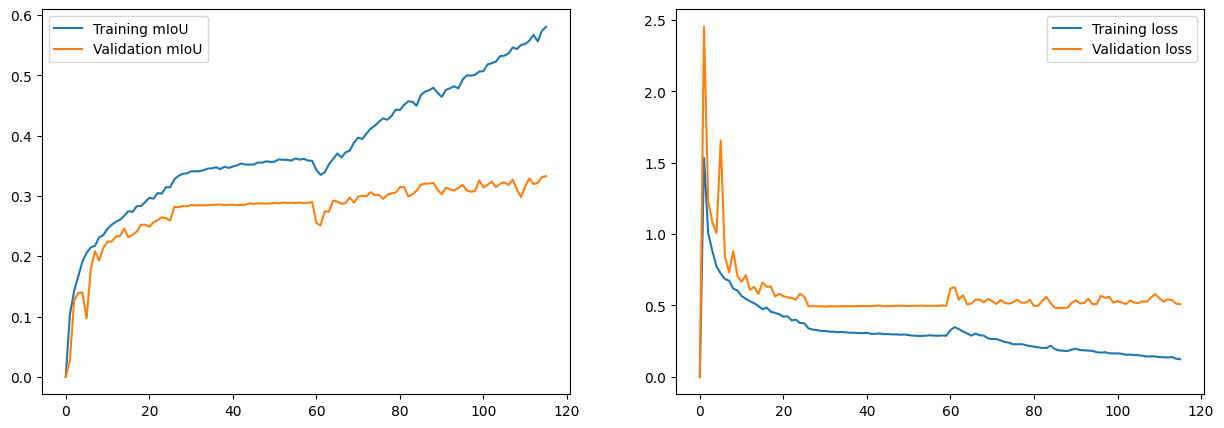

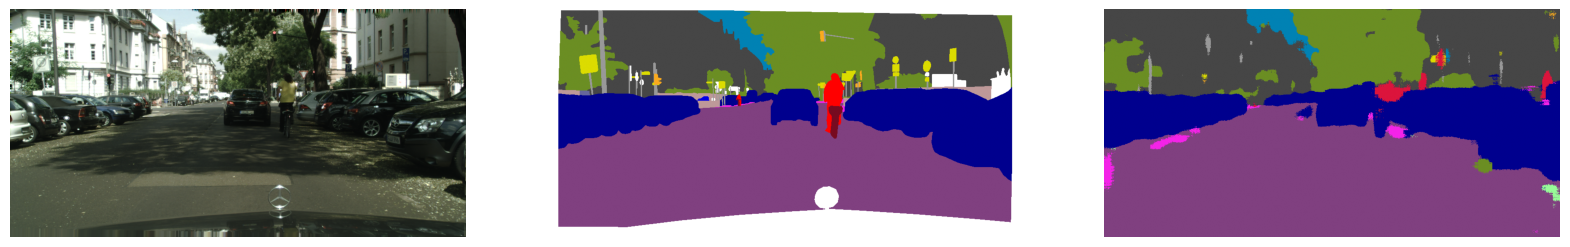

----------- EPOCH 117 -----------
  minibatch 0: train mIoU = 0.5348444581031799 train loss = 0.13220323622226715
  minibatch 40: train mIoU = 0.572900306887743 train loss = 0.12896028379114663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train mIoU=0.573, Val mIoU=0.324, Train loss=0.130, Val loss=0.522


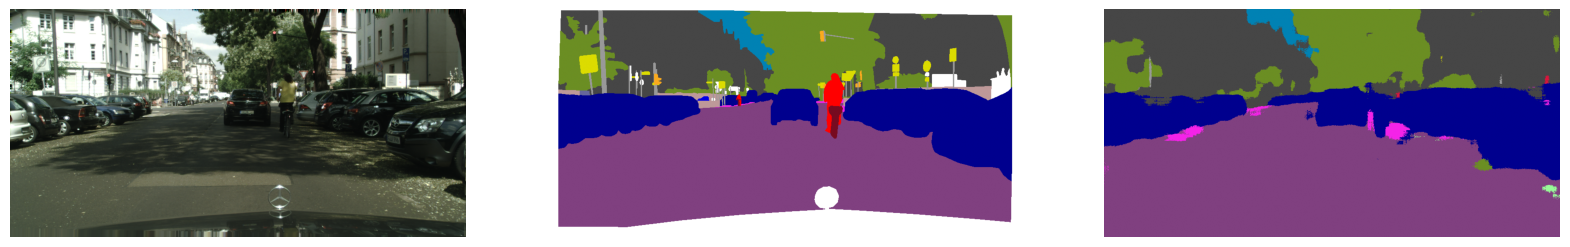

----------- EPOCH 118 -----------
  minibatch 0: train mIoU = 0.5656694173812866 train loss = 0.1021043211221695
  minibatch 40: train mIoU = 0.5789967978872904 train loss = 0.128015448407429


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train mIoU=0.580, Val mIoU=0.328, Train loss=0.127, Val loss=0.537


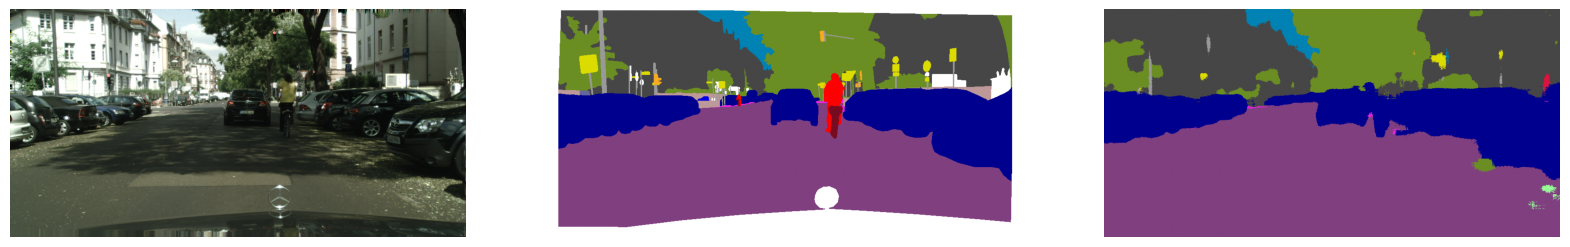

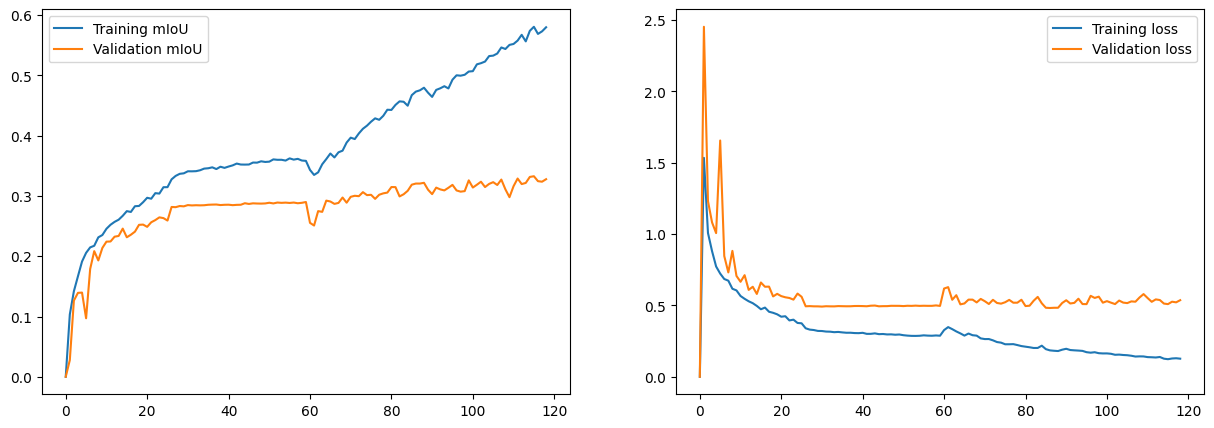

In [17]:
def load_model(path):
    checkpoint = torch.load(MODEL_PATH)
    net.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch'] + 1
    history = checkpoint['history']
    return epoch, history

if MODE == 'LOAD':
    epoch, history = load_model(MODEL_PATH)
    net.eval()
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
elif MODE == 'LOAD_AND_TRAIN':
    epoch, history = load_model(MODEL_PATH)
    print(f'Loaded pre-trained model at epoch {epoch}')
    plot_history(history)
    history = train(net, train_dataloader, val_dataloader, history, starting_epoch=epoch, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)
elif MODE == 'TRAIN':
    history = train(net, train_dataloader, val_dataloader, history=None, starting_epoch=0, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
    plot_history(history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


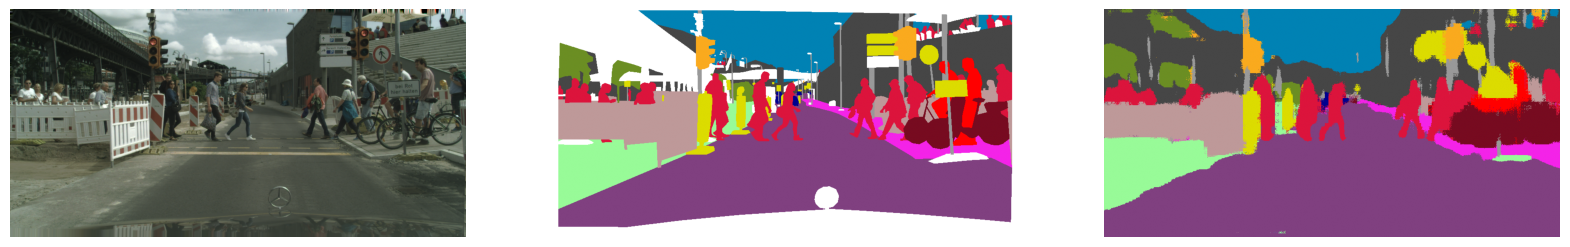

In [22]:
display_prediction(net, train_dataset, random=True)